In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data Wrangling

---

In [111]:
# loading data
df = pd.read_excel('C:/Users/shamr/Downloads/Data Science/Projects/Capstone/taiwan_default.xls', skiprows = 1, index_col = 0)

In [112]:
# renaming columns
df.columns = df.columns.str.lower().str.replace(" ","_")
months = ['sep', 'aug', 'jul', 'jun', 'may', 'apr']
variables = ['payment_status', 'bill_statement', 'previous_payment']
new_column_names = [x + '_' + y for x in variables for y in months]
rename_dict = {x: y for x, y in zip(df.loc[:, 'pay_0':'pay_amt6'].columns, new_column_names)}
df.rename(columns=rename_dict, inplace=True)

In [113]:
# creating dictionaries
gender_dict = {1: 'Male', 
               2: 'Female'}
education_dict = {0: 'Others',
                  1: 'Graduate School', 
                  2: 'University', 
                  3: 'High School', 
                  4: 'Others',
                  5: 'Others',
                  6: 'Others'}
marital_status_dict = {0: 'Others', 
                       1: 'Married', 
                       2: 'Single', 
                       3: 'Divorced'}
payment_status = {-2: 'NC',
                  -1: 'PF',
                  0: 'RC',
                  1: '1M_delay',
                  2: '2M_delay',
                  3: '3M_delay',
                  4: '4M_delay',
                  5: '5M_delay',
                  6: '6M_delay',
                  7: '7M_delay',
                  8: '8M_delay',
                  9: '9M_above_delay'}


In [114]:
# map numbers to strings
df.sex = df.sex.map(gender_dict)
df.education = df.education.map(education_dict)
df.marriage = df.marriage.map(marital_status_dict)

for column in [x for x in df.columns if ('status' in x)]:
    df[column] = df[column].map(payment_status)
    
# Save to csv
df.to_csv('../Capstone/credit_card_default.csv')

## Exploratory Data Analysis

---

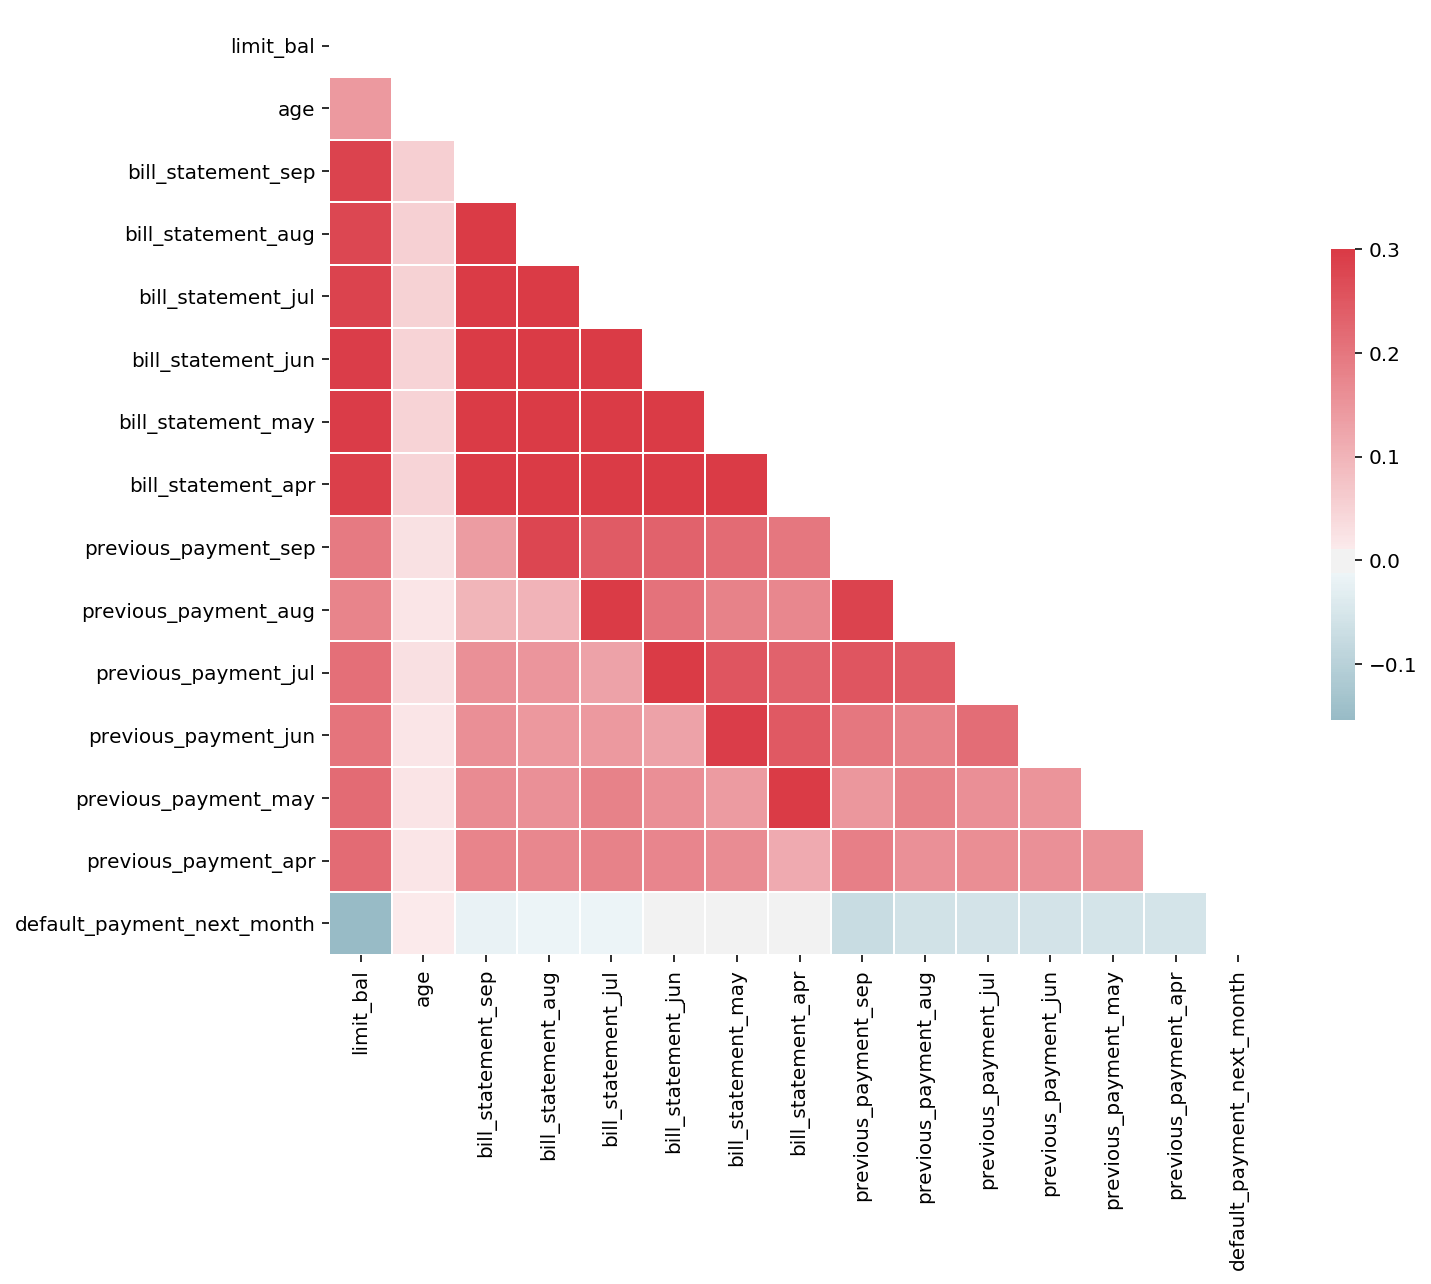

In [115]:
# correlation matrix
corr = df.select_dtypes(include = 'number').corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()

Text(0.5, 1.05, 'Pairplot')

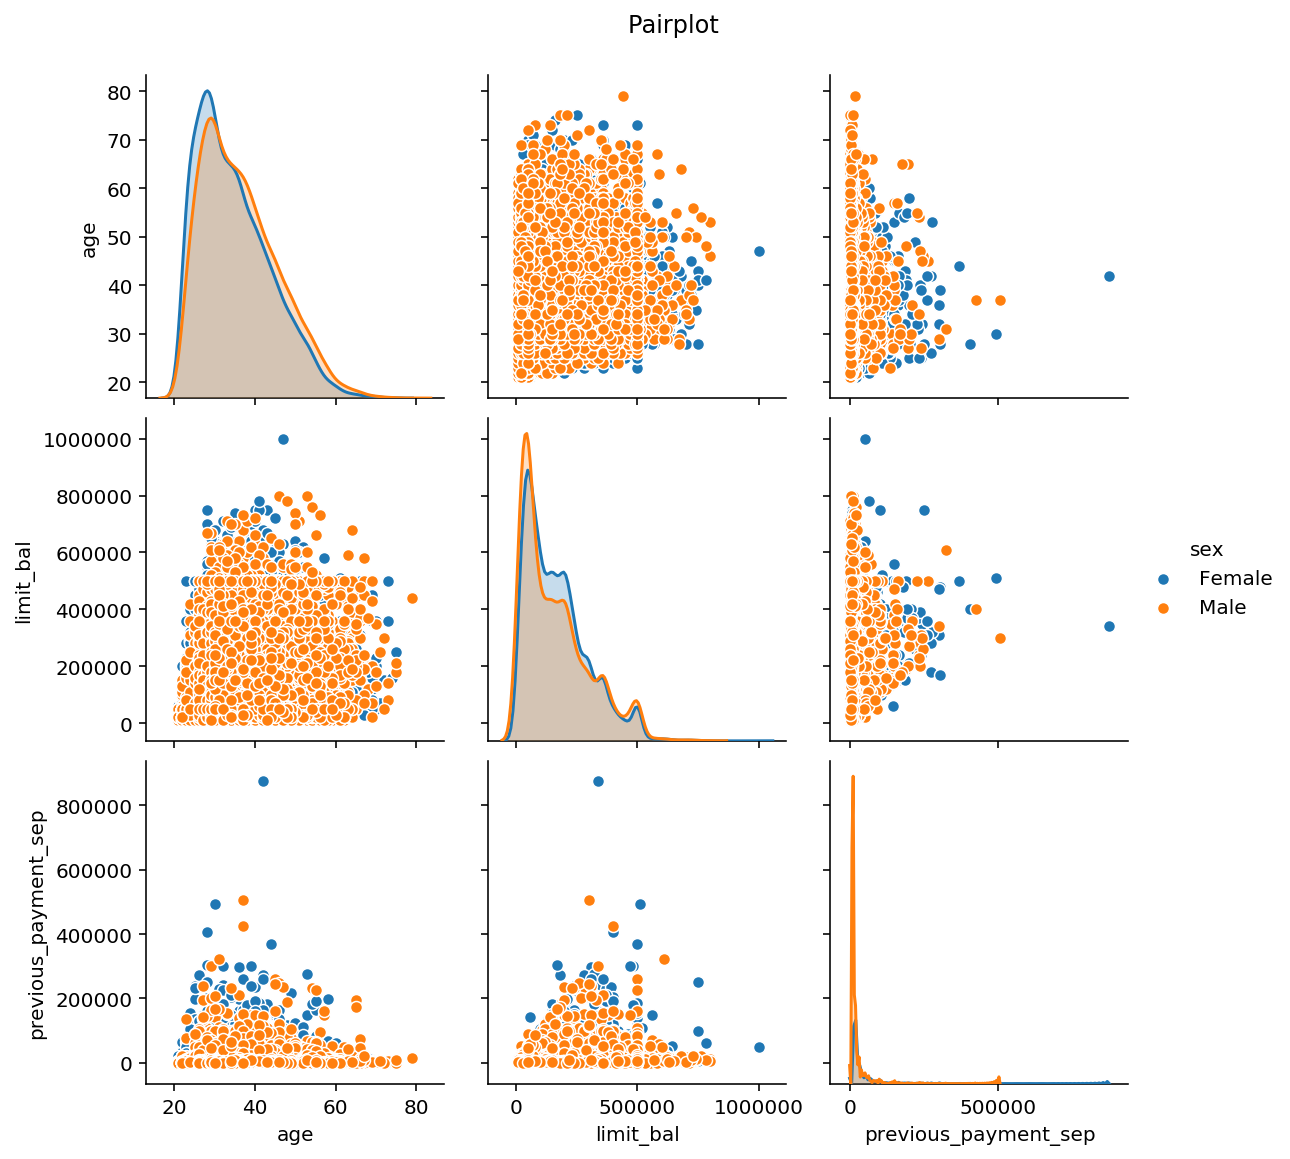

In [116]:
# pairplot of selected variables
pair_plot = sns.pairplot(df[['sex', 'age', 'limit_bal', 'previous_payment_sep']], hue='sex')
pair_plot.fig.suptitle('Pairplot', y=1.05)

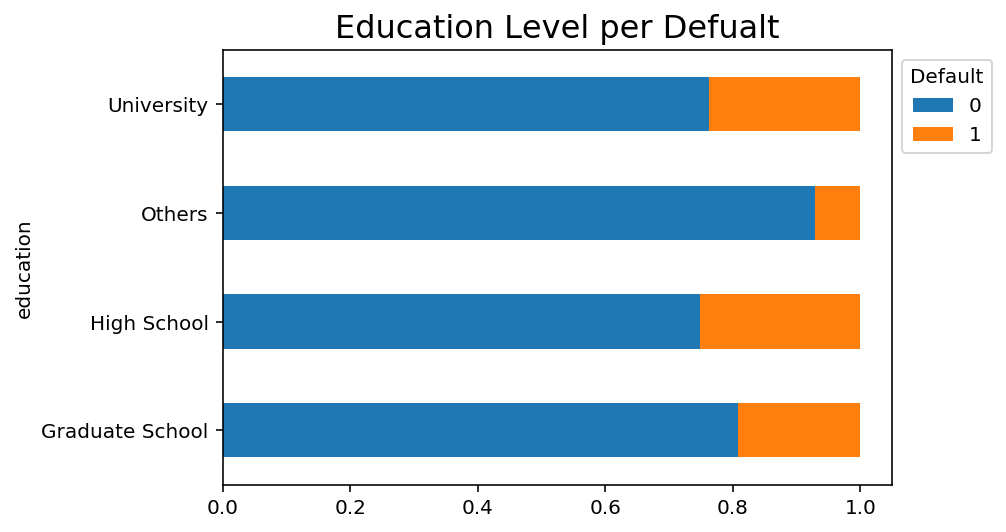

In [117]:
# percentage of defaults per education
ax = df.groupby('education')['default_payment_next_month'].value_counts(normalize=True).unstack().plot(kind='barh', stacked='True')
ax.set_title('Education Level per Defualt', fontsize=16)
ax.legend(title='Default', bbox_to_anchor=(1,1)) 
plt.show()

## Model Selection

---

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [119]:
# create copy of dataframe and assign target variable
X = df.copy()
y = X.pop('default_payment_next_month')

In [120]:
# select categorical features for one-hot encoding and instantiate
categorical_feat = X.select_dtypes(include= 'object').columns.tolist()
X = pd.get_dummies(X, prefix_sep = '_', drop_first = True).copy()

In [121]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Base Tree

In [122]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [123]:
# create the instance of the model, fit it to the training data and create prediction
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train, y_train)
y_pred_dt = tree_classifier.predict(X_test)

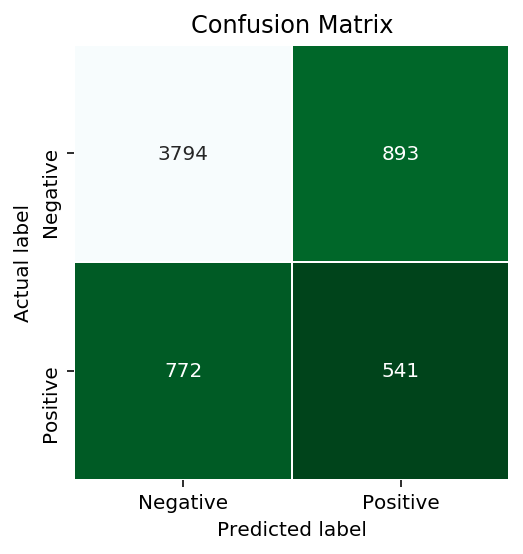

In [124]:
# evaluate performance
tree_cf_matrix = confusion_matrix(y_test,y_pred_dt)
labels = ['Negative', 'Positive']

f = sns.heatmap(tree_cf_matrix, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False)
f.set(xlabel='Predicted label', ylabel='Actual label', title='Confusion Matrix')
f.xaxis.set_ticklabels(labels)
f.yaxis.set_ticklabels(labels)
plt.savefig('base_cf.png')

### Hyperparameter Tuning - Base Tree

In [125]:
from sklearn.model_selection import (GridSearchCV, cross_val_score, RandomizedSearchCV, cross_validate, StratifiedKFold)
from sklearn.metrics import accuracy_score

In [126]:
# cross validation 
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

In [127]:
# cross validation evaluation
cross_val_score(tree_classifier, X_train, y_train, cv=k_fold)

array([0.73979167, 0.72270833, 0.7275    , 0.72958333, 0.72625   ])

In [128]:
# cross validation metrics
cross_validate(tree_classifier, X_train, y_train, cv=k_fold, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

{'fit_time': array([0.3901639 , 0.38751936, 0.41946745, 0.37947631, 0.40794706]),
 'score_time': array([0.00996351, 0.0121119 , 0.00997162, 0.01097155, 0.01193142]),
 'test_accuracy': array([0.73979167, 0.72270833, 0.7275    , 0.72958333, 0.72625   ]),
 'test_precision': array([0.41689128, 0.38112199, 0.39388646, 0.39644444, 0.3933162 ]),
 'test_recall': array([0.43609023, 0.40225564, 0.42347418, 0.41877934, 0.43098592]),
 'test_roc_auc': array([0.63142461, 0.60855968, 0.61913721, 0.61833714, 0.62040915])}

In [129]:
# defining parameters
param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': range(3, 11),
              'min_samples_leaf': range(2, 11)}

In [70]:
# instantiate grid search
classifier_gs = GridSearchCV(tree_classifier, param_grid, scoring='recall', cv=k_fold, n_jobs=4, verbose=1)
classifier_gs.fit(X_train, y_train)

# print results
print(f'Best parameters: {classifier_gs.best_params_}') 
print(f'Recall (Training set): {classifier_gs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, classifier_gs.predict(X_test)):.4f}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   24.8s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   39.6s finished


Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10}
Recall (Training set): 0.3658
Recall (Test set): 0.3580


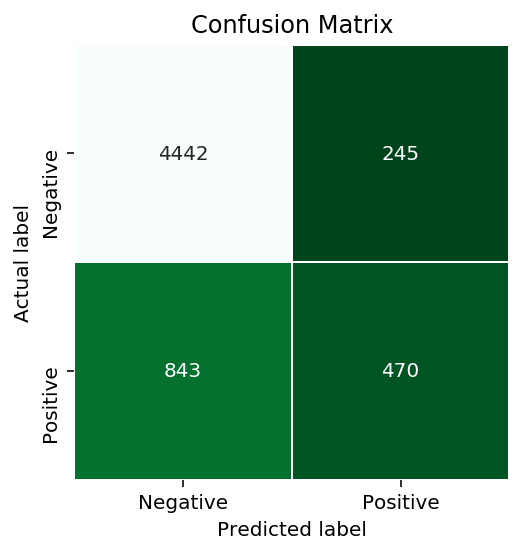

In [108]:
# evaluate performance
treeHT_cf_matrix = confusion_matrix(y_test,classifier_gs.predict(X_test))
labels = ['Negative', 'Positive']

g = sns.heatmap(treeHT_cf_matrix, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False)
g.set(xlabel='Predicted label', ylabel='Actual label', title='Confusion Matrix')
g.xaxis.set_ticklabels(labels)
g.yaxis.set_ticklabels(labels)
plt.savefig('baseHT_cf.png')

### Random Forest

In [74]:
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)

In [75]:
# create the instance of the model, fit it to the training data and create prediction
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

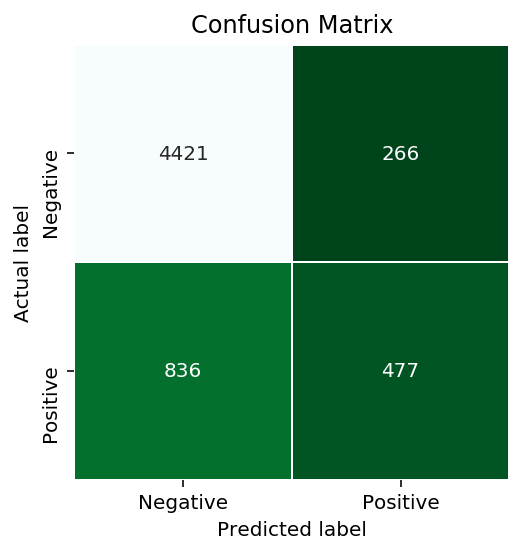

In [107]:
# evaluate performance
rf_cf_matrix = confusion_matrix(y_test,y_pred_rf)
labels = ['Negative', 'Positive']

h = sns.heatmap(rf_cf_matrix, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False)
h.set(xlabel='Predicted label', ylabel='Actual label', title='Confusion Matrix')
h.xaxis.set_ticklabels(labels)
h.yaxis.set_ticklabels(labels)
plt.savefig('rf_cf.png')

### XGBoost

In [82]:
from xgboost.sklearn import XGBClassifier

In [86]:
# create the instance of the model, fit it to the training data and create prediction
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

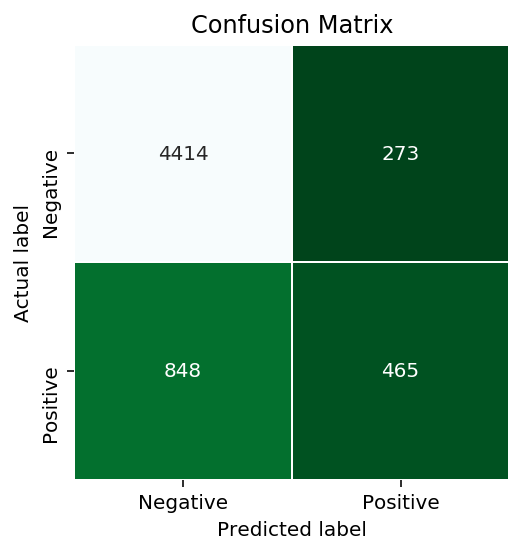

In [106]:
# evaluate performance
xgb_cf_matrix = confusion_matrix(y_test,y_pred_xgb)
labels = ['Negative', 'Positive']

i = sns.heatmap(xgb_cf_matrix, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False)
i.set(xlabel='Predicted label', ylabel='Actual label', title='Confusion Matrix')
i.xaxis.set_ticklabels(labels)
i.yaxis.set_ticklabels(labels)
plt.savefig('xg_cf.png')

### Hyperparameter Tuning - Random Forest

In [89]:
# cross validation 
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

In [90]:
# define parameters
rf_param_grid = {'n_estimators': np.linspace(100, 1000, 10, dtype=int),
                 'max_features': ['log2', 'sqrt', None],
                 'max_depth': np.arange(3, 11, 1, dtype=int),
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': np.arange(1, 51, 2, dtype=int),
                 'bootstrap': [True, False]}

In [94]:
# instantiate grid search
rf_rs =  RandomizedSearchCV(rf, rf_param_grid, scoring='recall', cv=k_fold, n_jobs=4, verbose=1, n_iter=100, random_state=42)
rf_rs.fit(X_train, y_train)

# print results
print(f'Best parameters: {rf_rs.best_params_}') 
print(f'Recall (Training set): {rf_rs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, rf_rs.predict(X_test)):.4f}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 22.6min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 55.7min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed: 66.5min finished


Best parameters: {'n_estimators': 900, 'min_samples_split': 5, 'min_samples_leaf': 21, 'max_features': None, 'max_depth': 10, 'bootstrap': True}
Recall (Training set): 0.3588
Recall (Test set): 0.3450


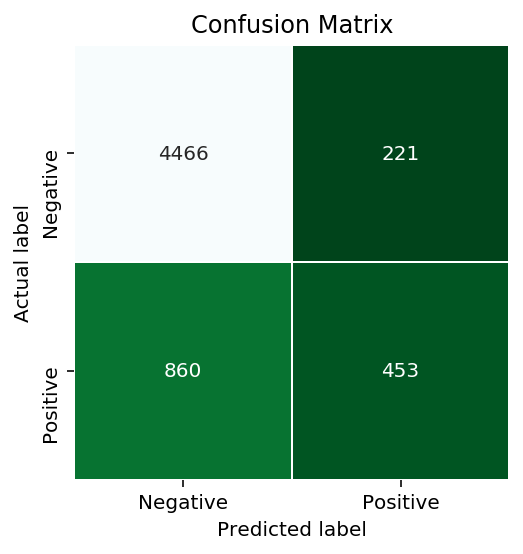

In [105]:
# evaluate performance
rfrs_cf_matrix = confusion_matrix(y_test,rf_rs.predict(X_test))
labels = ['Negative', 'Positive']

j = sns.heatmap(rfrs_cf_matrix, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False)
j.set(xlabel='Predicted label', ylabel='Actual label', title='Confusion Matrix')
j.xaxis.set_ticklabels(labels)
j.yaxis.set_ticklabels(labels)
plt.savefig('rfrs_cf.png')

### Hyperparameter Tuning - XGBoost

In [100]:
# define parameters
xgb_param_grid = {'n_estimators': np.linspace(100, 1000, 10, dtype=int),
                  'learning_rate': np.arange(0.05, 0.31, 0.05),
                  'max_depth': np.arange(3, 11, 1, dtype=int),
                  'min_child_weight': np.arange(1, 8, 1, dtype=int),
                  'colsample_bytree': np.linspace(0.3, 1, 7)}

In [101]:
# instantiate grid search
xgb_rs = RandomizedSearchCV(xgb, xgb_param_grid, scoring='recall', cv=k_fold, n_jobs=4, verbose=1, n_iter=100, random_state=42)
xgb_rs.fit(X_train, y_train)

# print results
print(f'Best parameters: {xgb_rs.best_params_}') 
print(f'Recall (Training set): {xgb_rs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, xgb_rs.predict(X_test)):.4f}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 16.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 45.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed: 52.2min finished


Best parameters: {'n_estimators': 700, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.25, 'colsample_bytree': 0.7666666666666666}
Recall (Training set): 0.3769
Recall (Test set): 0.3800


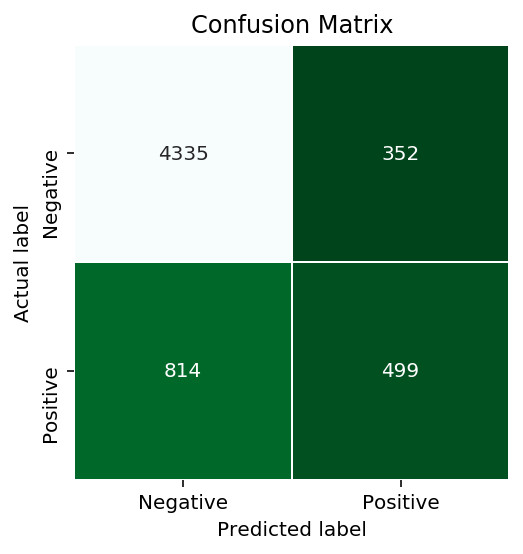

In [104]:
# evaluate performance
xgbrs_cf_matrix = confusion_matrix(y_test,xgb_rs.predict(X_test))
labels = ['Negative', 'Positive']

k = sns.heatmap(xgbrs_cf_matrix, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False)
k.set(xlabel='Predicted label', ylabel='Actual label', title='Confusion Matrix')
k.xaxis.set_ticklabels(labels)
k.yaxis.set_ticklabels(labels)
plt.savefig('xgbHT_cf.png')

## Model Comparison

---

In [37]:
# table to compare models
results_dict = {'decision_tree': tree_perf,
                'decision_tree_gs': tree_gs_perf,
                'random_forest': rf_perf,
                'random_forest_rs': rf_rs_perf,
                'xgboost': xgb_perf,
                'xgboost_rs': xgb_rs_perf}

results_comparison = pd.DataFrame(results_dict).T
results_comparison


,accuracy,precision,recall,specificity,f1_score,cohens_kappa,roc_auc,pr_auc
decision_tree,0.722500,0.377266,0.412034,0.809473,0.393884,0.214395,0.612107,0.459689
decision_tree_gs,0.818667,0.657343,0.357959,0.947728,0.463511,0.365623,0.750558,0.532866
random_forest,0.816333,0.641992,0.363290,0.943247,0.464008,0.363305,0.757854,0.523795
random_forest_rs,0.819833,0.672107,0.345011,0.952848,0.455964,0.361116,0.779990,0.540329
xgboost,0.813167,0.630081,0.354151,0.941754,0.453437,0.351274,0.766265,0.524399
xgboost_rs,0.805667,0.586369,0.380046,0.924899,0.461183,0.349165,0.752221,0.502064
